# load model

In [30]:
from model import Model 
from pathlib import Path
import torch
from process_data import preprocess
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np
PATH = Path("Ensamble_handin/model.pth").absolute()


IMAGE_SET_SIZE = 1000
BATCH_SIZE = 10

In [31]:
model = Model()
model.load_state_dict(torch.load(PATH))
model.to("cuda")

EnsambleModel(
  (e): pre_trained_encoder(
    (e1): encoder_block(
      (conv): conv_block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
      )
      (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (e2): encoder_block(
      (conv): conv_block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
import os 
import sys
sys.path.insert(0, os.getcwd())

from DataLoader import *
from utils import LABELS, map_id_to_train_id, train_id_to_name, remove_classes_from_tensor
from DataVisualizations import visualize_criterion
from train_utils import _init_wandb, _print_quda_info, load_model_weights, log_dice_loss, ModelEvaluator, save_model

ModuleNotFoundError: No module named 'DataLoader'

## Load different datasets

In [32]:

class RandomNoiseDataset(Dataset):
    def __init__(self, num_images, image_size=(512, 1024)):
        self.num_images = num_images
        self.image_size = image_size

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx) -> Image:
        random_data = np.random.randint(0, 256, (*self.image_size, 3), dtype=np.uint8)
        im = Image.fromarray(random_data)
        im = preprocess(im)
        return im , [0]

random_noise_dataloader_dataset = RandomNoiseDataset(IMAGE_SET_SIZE)
random_noise_dataloader = DataLoader(random_noise_dataloader_dataset, batch_size=BATCH_SIZE, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


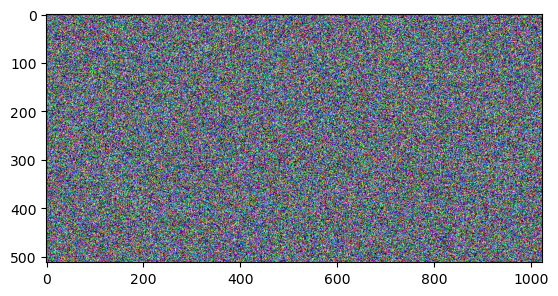

In [33]:
for i, (data,_) in enumerate(random_noise_dataloader):
    
    plt.imshow(data[0].squeeze(0).permute(1,2,0))
    break

In [34]:

class RandomConstantDataset(Dataset):
    def __init__(self, num_images, image_size=(512, 1024)):
        self.num_images = num_images
        self.image_size = image_size

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx) -> Image:
        color = np.random.randint(0, 256, size=3)  # Choose a random color
        image_data = np.full((*self.image_size, 3), color, dtype=np.uint8)
        im = Image.fromarray(image_data)
        im = preprocess(im)
        return im , [0] 

constant_image_dataset = RandomConstantDataset(IMAGE_SET_SIZE)
constant_image_dataloader = DataLoader(constant_image_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [35]:
# cifar 100 image
from torchvision import datasets, transforms
from torch.utils.data import Subset
path = Path("C:/Users/20193696/Desktop/Y5Q3/DeepLearning/data")

cifar_100_dataset = datasets.CIFAR100(root=path, train=True, download=True, transform=preprocess)
# Create a new dataset that only includes the first 100 images
subset_cifar_100_dataset = Subset(cifar_100_dataset, indices=range(IMAGE_SET_SIZE))
# Create a dataloader for the subset
cifar_100_dataloader = torch.utils.data.DataLoader(subset_cifar_100_dataset, batch_size=BATCH_SIZE, shuffle=True)



Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


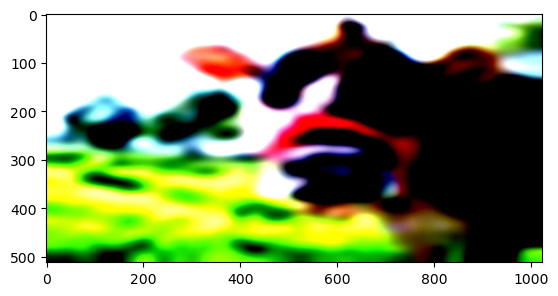

In [36]:
for i, (data,_) in enumerate(cifar_100_dataloader):
    plt.imshow(data[0].squeeze(0).permute(1,2,0))
    break

In [37]:
# # cittysckapes unseen data
# from dataclasses import dataclass


# @dataclass
# class Fake_args():
#     figure_size: int = 8
#     data_path: str = './data'
#     batch_size: int = 32
#     workers = 4 
# args = Fake_args()
# _ , val_loader = generate_data_loaders(args)

# predict on generated data

In [38]:
# general function that makes predictions based on a dataloader and returns the mean activation: 
def predict_on_data_loader(dataloader):
    mean_activations = []
    for i, (data, _ ) in enumerate(dataloader):
        with torch.no_grad():
            data = data.squeeze(1)
            data = data.to('cuda')
            output,_ = model(data)
            softmax_score_per_pixel, _ = torch.max(output.permute(0,2,3,1), dim=3)
            mean_softmax_score_per_image = torch.mean(softmax_score_per_pixel,dim=(1,2))
            mean_activations.extend(mean_softmax_score_per_image.tolist())

    return mean_activations

In [39]:
data_loaders = {"RandomConstantDataset": constant_image_dataloader,
                "RandomNoiseDataset": random_noise_dataloader,
                "Cifar100": cifar_100_dataloader}#,
                #"Cityscapes": val_loader}

In [40]:
dataset_mean_activations = {}
model.eval()
for key, dataloader in data_loaders.items():
    mean_activation = predict_on_data_loader(dataloader)
    dataset_mean_activations[key] = mean_activation
    print(f"Mean activation for {key}: {np.mean(mean_activation)}")

OOD: True, mean_softmax_score_of_image: 0.41448497772216797
OOD: True, mean_softmax_score_of_image: 0.46869856119155884
OOD: True, mean_softmax_score_of_image: 0.4495367109775543
OOD: True, mean_softmax_score_of_image: 0.45679935812950134
OOD: True, mean_softmax_score_of_image: 0.48657098412513733
OOD: True, mean_softmax_score_of_image: 0.4564593434333801
OOD: True, mean_softmax_score_of_image: 0.44236746430397034
OOD: True, mean_softmax_score_of_image: 0.45535507798194885
OOD: True, mean_softmax_score_of_image: 0.5115094184875488
OOD: True, mean_softmax_score_of_image: 0.5142415165901184
Mean activation for RandomConstantDataset: 0.4656023305654526


## visualize 2d max activation

In [ ]:
import seaborn as sns
def plot_mean_activations(mean_activations):
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    for distr_name, distr in mean_activations.items():
        sns.histplot(distr, bins=100, ax=ax, label=distr_name, kde=True)
    
    ax.set_title('Mean Activations')
    ax.set_xlabel('Activation Value')
    ax.set_ylabel('Frequency')
    plt.legend()
    plt.show()
    plt.savefig("mean_activations.png")


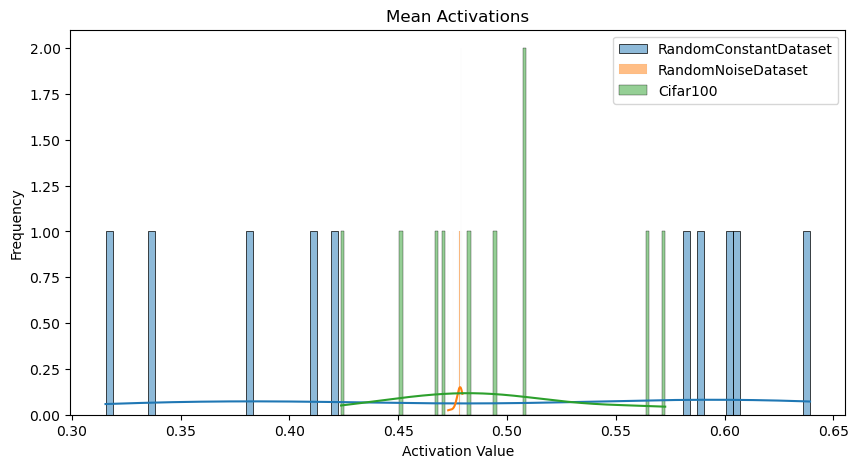

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_mean_activations(dataset_mean_activations)

## Visualize 3d simmelarity